# STOCK PREDICTION ML

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV

from eodhd import APIClient
from yahooquery import search

## YFINANCE

Nos fijamos siempre en `'symbol'`

In [2]:
result = search('tesla')
result

{'explains': [],
 'count': 15,
 'quotes': [{'exchange': 'NMS',
   'shortname': 'Tesla, Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA',
   'index': 'quotes',
   'score': 24759.0,
   'typeDisp': 'Equity',
   'longname': 'Tesla, Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Consumer Cyclical',
   'sectorDisp': 'Consumer Cyclical',
   'industry': 'Auto Manufacturers',
   'industryDisp': 'Auto Manufacturers',
   'dispSecIndFlag': True,
   'isYahooFinance': True},
  {'exchange': 'SAO',
   'shortname': 'TESLA INC   DRN',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA34.SA',
   'index': 'quotes',
   'score': 20010.0,
   'typeDisp': 'Equity',
   'longname': 'Tesla, Inc.',
   'exchDisp': 'São Paulo',
   'sector': 'Consumer Cyclical',
   'sectorDisp': 'Consumer Cyclical',
   'industry': 'Auto Manufacturers',
   'industryDisp': 'Auto Manufacturers',
   'isYahooFinance': True},
  {'exchange': 'NEO',
   'shortname': 'TESLA, INC. CDR (CAD HEDGED)',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA.NE'

Descargamos el historial de los ultimos 3 años de TESLA

In [3]:
tesla = yf.Ticker('TSLA')
tesla = tesla.history(period = '3y', interval = '1d')

In [4]:
tesla.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-08-11 00:00:00-04:00,335.00000000,346.64001465,334.14999390,339.02999878,105320200,0.00000000,0.00000000
2025-08-12 00:00:00-04:00,345.00000000,345.26000977,332.94000244,340.83999634,80522100,0.00000000,0.00000000
2025-08-13 00:00:00-04:00,341.50000000,348.98001099,338.20001221,339.38000488,67838900,0.00000000,0.00000000
2025-08-14 00:00:00-04:00,335.76000977,340.47000122,330.39999390,335.57998657,75000700,0.00000000,0.00000000
2025-08-15 00:00:00-04:00,337.66000366,339.29998779,327.01998901,330.55999756,74319800,0.00000000,0.00000000
2025-08-18 00:00:00-04:00,329.61999512,336.26998901,329.58999634,335.16000366,56956600,0.00000000,0.00000000
2025-08-19 00:00:00-04:00,335.79000854,340.54998779,327.85000610,329.30999756,75956000,0.00000000,0.00000000
2025-08-20 00:00:00-04:00,329.22000122,331.36999512,314.60000610,323.89999390,77481800,0.00000000,0.00000000
2025-08-21 00:00:00-04:00,322.07998657,324.89999390,318.67999268,320.10998535,55744400,0.00000000,0.00000000


Nos quedamos con la columna que nos interesa

In [5]:
df = tesla[['Close']].copy()
df

,Close
Date,
2022-08-23 00:00:00-04:00,296.45333862
2022-08-24 00:00:00-04:00,297.09667969
2022-08-25 00:00:00-04:00,296.07000732
2022-08-26 00:00:00-04:00,288.08999634
2022-08-29 00:00:00-04:00,284.82000732
...,...
2025-08-18 00:00:00-04:00,335.16000366
2025-08-19 00:00:00-04:00,329.30999756
2025-08-20 00:00:00-04:00,323.89999390


Miramos la grafica de la columna `Close` de dos maneras diferentes

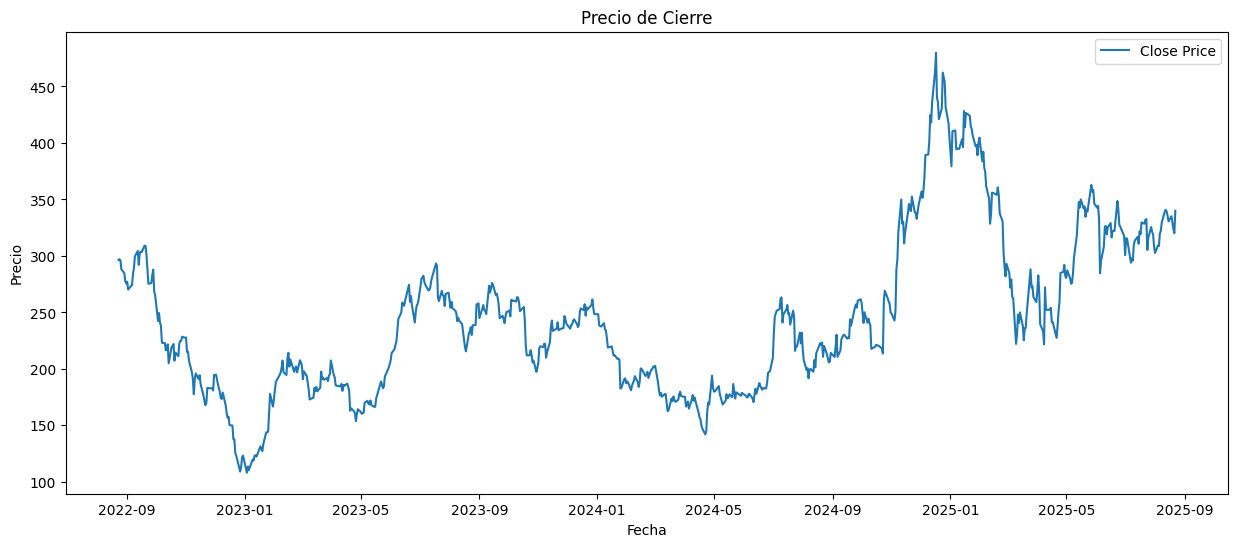

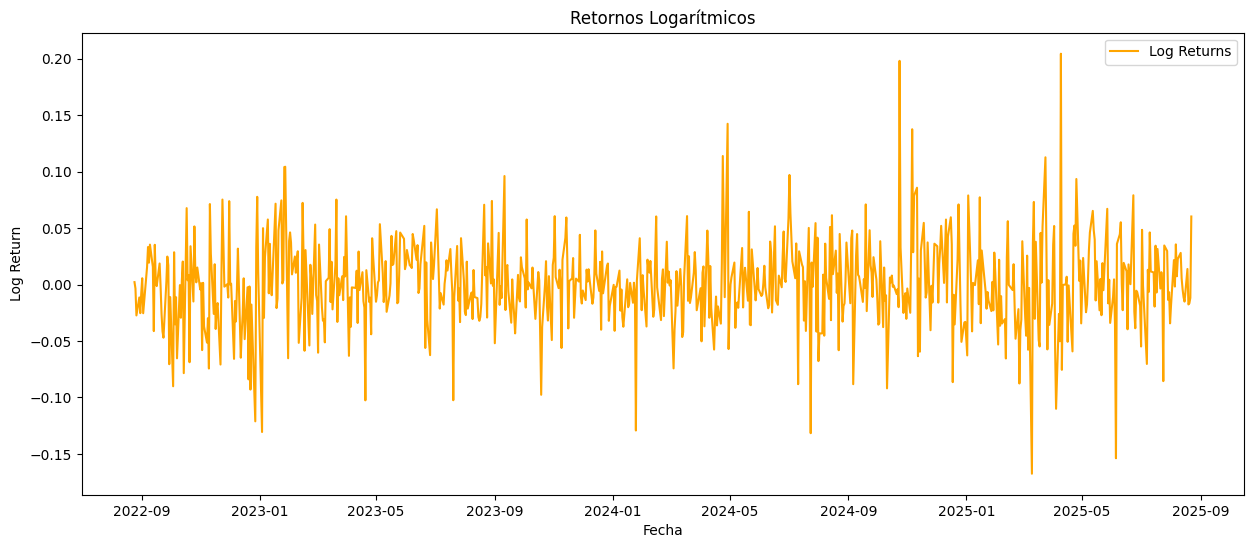

In [6]:
# 1. Serie original (Close)
plt.figure(figsize=(15,6))
plt.plot(df['Close'], label='Close Price')
plt.title("Precio de Cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()

# 2. Retornos logarítmicos
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

plt.figure(figsize=(15,6))
plt.plot(df['LogReturn'], label='Log Returns', color='orange')
plt.title("Retornos Logarítmicos")
plt.xlabel("Fecha")
plt.ylabel("Log Return")
plt.legend()
plt.show()

### SERIE ORIGINAL

In [7]:
df.shape

(753, 2)

In [8]:
serie_original = df[['Close']].copy()
serie_original = serie_original.iloc[:-1]
serie_original

,Close
Date,
2022-08-23 00:00:00-04:00,296.45333862
2022-08-24 00:00:00-04:00,297.09667969
2022-08-25 00:00:00-04:00,296.07000732
2022-08-26 00:00:00-04:00,288.08999634
2022-08-29 00:00:00-04:00,284.82000732
...,...
2025-08-15 00:00:00-04:00,330.55999756
2025-08-18 00:00:00-04:00,335.16000366
2025-08-19 00:00:00-04:00,329.30999756


Creamos una variable que se llama `ventana_inicial` para que el `Walk-forward Validation` sepa cuántos datos usará para el primer entrenamiento

In [9]:
ventana_inicial = 500

if len(serie_original) <= ventana_inicial:
    raise ValueError("No hay suficientes datos para la validación.")

En ``walk-forward``, la lógica es:

1. Entreno un modelo con los datos desde t₁ hasta tₖ → esa parte inicial es la ventana_inicial.

2. Predigo el siguiente punto (tₖ₊₁).

3. Añado el dato real al entrenamiento.

4. Repito: entreno desde t₁ hasta tₖ₊₁ → predigo tₖ₊₂, etc.

**¿Cómo funciona internamente?**

``Train inicial`` → toma los primeros ventana_inicial datos

``Test`` → predice el dato siguiente (h=1)

``Añade ese dato a train`` → vuelve a entrenar → predice el próximo

Repite hasta llegar al final de la serie

In [10]:
cv = SlidingWindowForecastCV(window_size=ventana_inicial, step=1, h=1)
errors, preds, trues = [], [], []

Ahora usamos ``Walk-forward CV con SlidingWindowForecastCV``

``SlidingWindowForecastCV`` solo define cómo se va a mover la ventana de entrenamiento/prueba, pero todavía no sabe sobre qué datos trabajar

``window_size = ventana_inicial`` → Le dice: «toma los primeros **ventana_inicial** valores de la serie como entrenamiento»»

``step = 1`` → Después de predecir, mueve la ventana 1 dato hacia adelante, para incluir el siguiente punto en el entrenamiento y repetir el proceso.

``h = 1``→ Horizonte de predicción = 1 → «solo quiero predecir el siguiente dato cada vez»»
(también se conoce como 1-step ahead forecasting).

``cv`` es un objeto de tipo ``SlidingWindowForecastCV``, que sabe cómo mover una ventana por una serie temporal.

``.split(logret)`` corta tu serie de ``LogReturn`` en ventanas temporales, simulando un proceso de **entrenar → predecir → avanzar → volver a entrenar.**

En cada paso del bucle te devuelve dos cosas:

``train``: una ventana de datos históricos (por ejemplo, los primeros 500 logreturns)

``test``: el dato siguiente justo después de esa ventana → lo que quieres predecir

In [11]:
for train, test in cv.split(serie_original):
    m = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    p = m.predict(n_periods=1)[0]
    t = test[0]

    preds.append(p)
    trues.append(t)
    errors.append((t - p)**2)

rmse = np.sqrt(np.mean(errors))
print(f"\nRMSE walk-forward: {rmse}")

c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


RMSE walk-forward: 3.7587560684407496e-06


c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


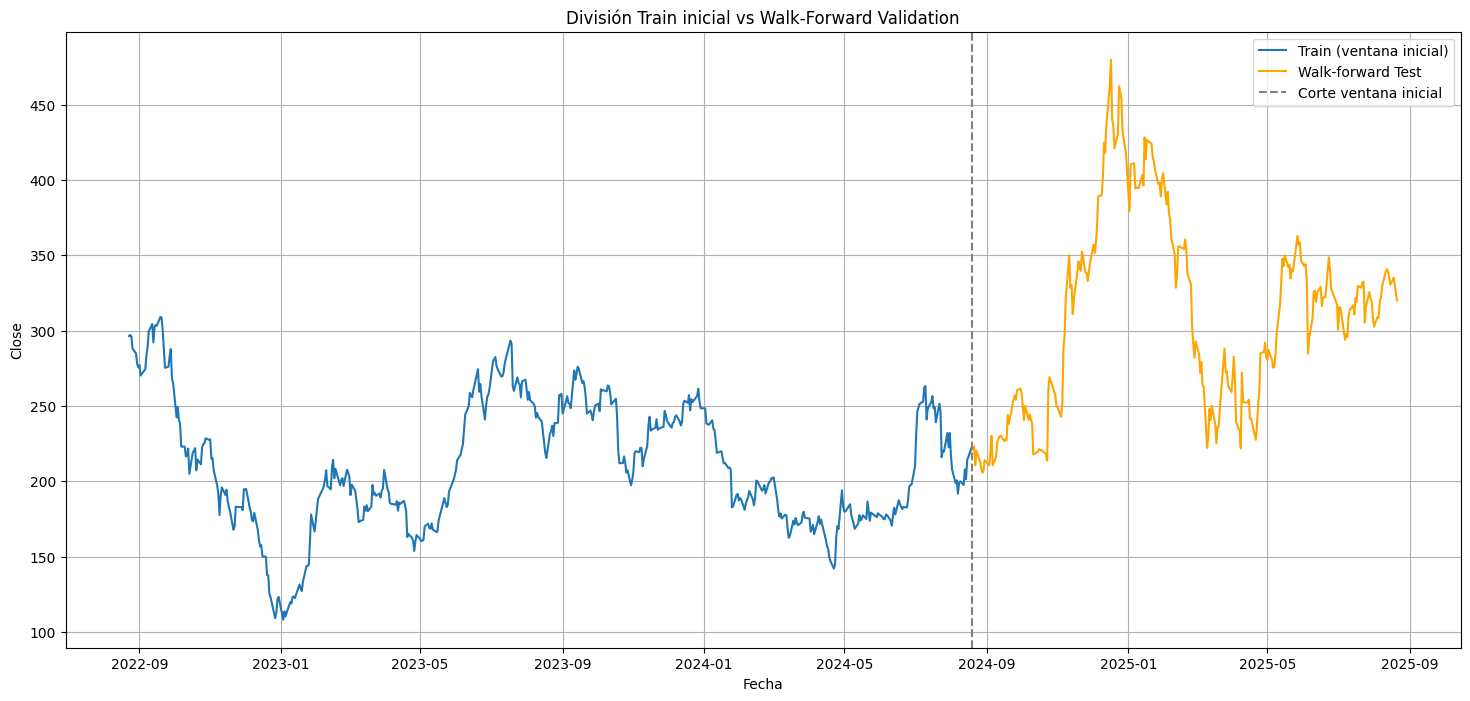

In [12]:
# Definimos las zonas
train = serie_original.iloc[:ventana_inicial]
test  = serie_original.iloc[ventana_inicial:]

# Dibujamos
plt.figure(figsize=(18,8))
plt.plot(train.index, train, label='Train (ventana inicial)')
plt.plot(test.index, test, label='Walk-forward Test', color='orange')
plt.axvline(train.index[-1], linestyle='--', color='gray', label='Corte ventana inicial')
plt.title('División Train inicial vs Walk-Forward Validation')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

``serie`` → es tu serie completa de precios de cierre **(Close)**.

``auto_arima`` busca automáticamente los mejores **hiperparámetros (p,d,q)** para un modelo ARIMA que se ajuste a esa serie.

``seasonal=False`` → le decimos que no busque estacionalidad (porque trabajamos con datos diarios y no queremos SARIMA).

``stepwise=True`` → hace que la búsqueda sea más rápida usando un método inteligente.

El resultado (**final_model**) ya queda entrenado con TODOS tus datos históricos.

In [13]:
final_model = auto_arima(serie_original, seasonal=False, stepwise=True, suppress_warnings=True)

pred = final_model.predict(n_periods=1)
pred_value = pred.iloc[0]

print(f"\nPredicción Close: {pred_value:.4f}")

c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


Predicción Close: 319.3845


c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### SERIE LOG RETURN

Un LogReturn = 0.01 → +1% de subida aprox.

Un LogReturn = -0.02 → -2% de bajada aprox.

Valores cercanos a 0 → poca variación.

Es el porcentaje de subida/bajada del dia anterior al actual

In [14]:
serie_original

,Close
Date,
2022-08-23 00:00:00-04:00,296.45333862
2022-08-24 00:00:00-04:00,297.09667969
2022-08-25 00:00:00-04:00,296.07000732
2022-08-26 00:00:00-04:00,288.08999634
2022-08-29 00:00:00-04:00,284.82000732
...,...
2025-08-15 00:00:00-04:00,330.55999756
2025-08-18 00:00:00-04:00,335.16000366
2025-08-19 00:00:00-04:00,329.30999756


In [15]:
logret = np.log(serie_original / serie_original.shift(1)).dropna()
logret

,Close
Date,
2022-08-24 00:00:00-04:00,0.00216777
2022-08-25 00:00:00-04:00,-0.00346167
2022-08-26 00:00:00-04:00,-0.02732302
2022-08-29 00:00:00-04:00,-0.01141549
2022-08-30 00:00:00-04:00,-0.02531599
...,...
2025-08-15 00:00:00-04:00,-0.01507216
2025-08-18 00:00:00-04:00,0.01381986
2025-08-19 00:00:00-04:00,-0.01760849


## EODHD

### Installing library

In [69]:
%pip install eodhd

Note: you may need to restart the kernel to use updated packages.


In [70]:
api = APIClient(api_key='68a888ecbf2185.97717291')

In [71]:
TICKERS = ["AAPL.US", "GOOGL.US", "TSLA.US", "JNJ.US", "JPM.US", "ITX.MC"]

**AAPL.US → Apple Inc.** (tecnología, iPhone, iPad, Mac).

**GOOGL.US → Alphabet Inc. Clase A** (matriz de Google, YouTube, Android).

**TSLA.US → Tesla Inc.** (vehículos eléctricos, baterías, energía).

**JNJ.US → Johnson & Johnson** (farmacéutica y productos de consumo, muy estable).

**JPM.US → JPMorgan Chase & Co.** (banco de inversión y comercial, uno de los más grandes del mundo).

**ITX.MC → Inditex S.A.** (España, grupo textil dueño de Zara, Pull&Bear, Massimo Dutti, etc., cotiza en la Bolsa de Madrid).

In [72]:
for i in TICKERS:
    df = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol= i, period='d', from_date='2010-01-01'))
    df.to_csv(f'{i}.csv', index=False)

### Data

In [3]:
df = pd.read_csv('../data/AAPL.US.csv', parse_dates=['date'])    #asegurar que los datos estan en orden
df = df.sort_values('date').reset_index(drop=True)
df

,date,open,high,low,close,adjusted_close,volume
0,2010-01-04,213.43000000,214.49960000,212.38000000,214.00960000,6.42460000,493729600
1,2010-01-05,214.60040000,215.58880000,213.25080000,214.37920000,6.43570000,601904800
2,2010-01-06,214.37920000,215.23040000,210.75040000,210.96880000,6.33330000,552160000
3,2010-01-07,211.75000000,211.99920000,209.05080000,210.57960000,6.32160000,477131200
4,2010-01-08,210.29960000,211.99920000,209.05920000,211.97960000,6.36370000,447610800
...,...,...,...,...,...,...,...
3929,2025-08-18,231.70000000,233.12000000,230.11000000,230.89000000,230.89000000,37476200
3930,2025-08-19,231.28000000,232.87000000,229.35000000,230.56000000,230.56000000,39402600
3931,2025-08-20,229.98000000,230.47000000,225.77000000,226.01000000,226.01000000,42263900
3932,2025-08-21,226.27000000,226.52000000,223.78000000,224.90000000,224.90000000,30621200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3934 non-null   datetime64[ns]
 1   open            3934 non-null   float64       
 2   high            3934 non-null   float64       
 3   low             3934 non-null   float64       
 4   close           3934 non-null   float64       
 5   adjusted_close  3934 non-null   float64       
 6   volume          3934 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 215.3 KB


In [4]:
df.describe()

,date,open,high,low,close,adjusted_close,volume
count,3934,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000
mean,2017-10-26 03:59:45.358414080,243.78418597,246.18414865,241.30518088,243.83255048,73.40398716,222902764.33655313
min,2010-01-04 00:00:00,90.00000000,90.70000000,89.47000000,90.28000000,5.76540000,23234700.00000000
25%,2013-11-27 12:00:00,141.62250000,143.18250000,140.23750000,141.80750000,17.98060000,80596025.00000000
50%,2017-10-24 12:00:00,187.73000000,189.28500000,186.09500000,187.93500000,37.18140000,134442000.00000000
75%,2021-09-21 18:00:00,315.29970000,318.23680000,312.15000000,315.29940000,138.53215000,298661300.00000000
max,2025-08-22 00:00:00,702.41080000,705.07080000,699.56880000,702.10000000,258.10380000,1880998000.00000000
std,NaN,145.01751975,146.26738489,143.49089401,144.89900035,70.57924376,216345358.96828377


In [5]:
df.isnull().value_counts()

date   open   high   low    close  adjusted_close  volume
False  False  False  False  False  False           False     3934
Name: count, dtype: int64

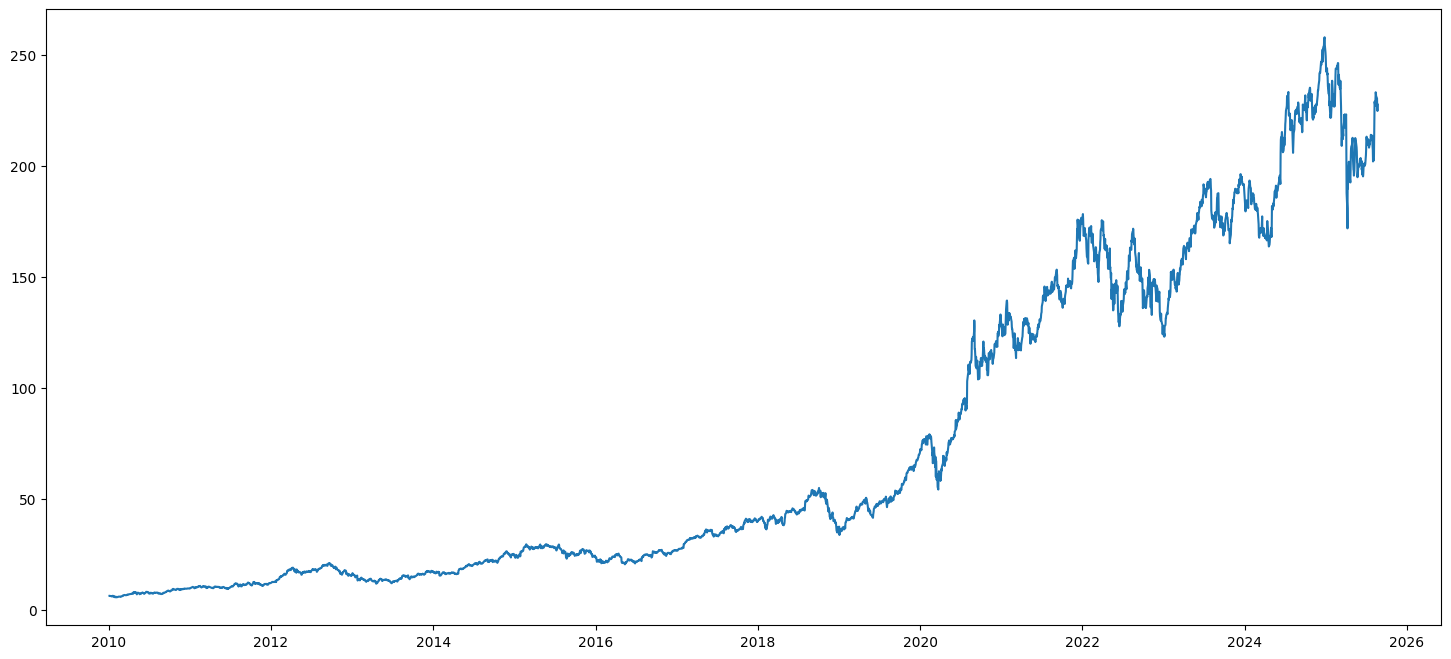

In [6]:
plt.figure(figsize=(18,8))
plt.plot(df["date"], df["adjusted_close"])

### Feature engineering

In [7]:
df.index = df["date"]
df.drop("date", axis=1, inplace=True)

df.index = pd.to_datetime(df.index)
df = df.copy()
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

##### NO ESTACIONARIA

In [11]:
print('p-value:', adfuller(df.adjusted_close)[1])

p-value: 0.9910750009953988


##### ESTACIONARIA

In [7]:
print('p-value:', adfuller(df.adjusted_close.diff(periods = 1).dropna())[1])

p-value: 1.2563734874046104e-21


Vimos que al diferenciar una vez los valores originales, la serie se volvió estacionaria. Pero este proceso también metió algo de ruido en los datos. Para compensarlo, añadimos una nueva variable que ayuda al modelo a explicar esas variaciones extra y, con ello, a entender mejor los patrones reales que hay en la serie.

In [8]:
df["close_diff_1"] = df.adjusted_close.diff(periods=1)

##### Autocorrelación parcial (Partial Autocorrelation, PACF)

##### Autocorrelación (ACF)
La **autocorrelación** mide cuánto se parece una serie a sí misma con cierto **retardo (lag)**.  

- Lag 1: relación entre \(y_t\) y \(y_{t-1}\)  
- Lag 2: relación entre \(y_t\) y \(y_{t-2}\)  
- etc.  

Se calcula con la función de autocorrelación (ACF).

---

##### Autocorrelación parcial (PACF)
La **autocorrelación parcial** mide la **relación directa** entre \(y_t\) y \(y_{t-k}\), eliminando la influencia de los lags intermedios.

- **ACF** = relación total (directa + indirecta).  
- **PACF** = relación directa (pura).

---

##### Utilidad en modelos ARIMA
En los modelos ARIMA:  
- La **ACF** ayuda a identificar el orden de la parte **MA (Moving Average)**.  
- La **PACF** ayuda a identificar el orden de la parte **AR (Autoregressive)**.  

Ejemplo:  
- Si la PACF corta en lag 2, puede sugerir un modelo **AR(2)**.  
- Si la ACF corta en lag 1, puede sugerir un modelo **MA(1)**.

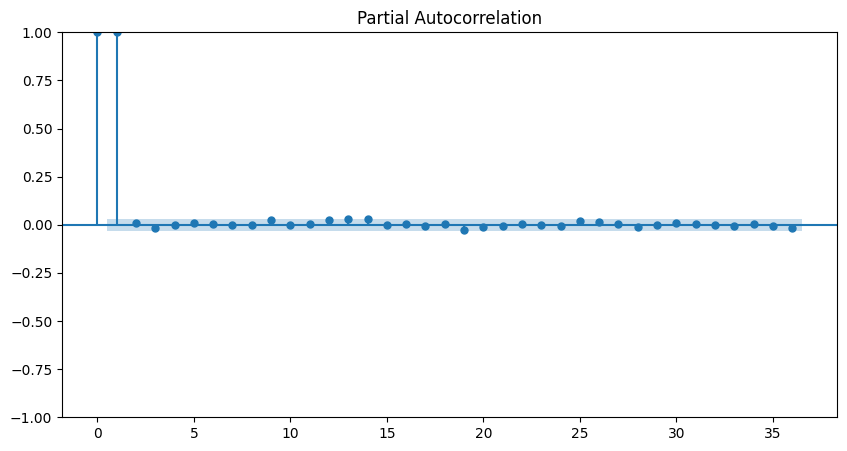

In [9]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['adjusted_close'], method='ywm')
plt.show()

Los datos muestran una autocorrelación significativa en el lag 1. Por lo tanto, introduciremos una variable que represente el precio lag en 1 periodo.

In [9]:
df["adjusted_close(-1)"] = df['adjusted_close'].shift(1)

In [10]:
df["SMA"] = df["adjusted_close"].rolling(window= 13).mean()

``Simple Moving Average (SMA)``: Averages the closing prices over a specified window, smoothing out price fluctuations and highlighting trends.

In [11]:
df["EMA"] = df["adjusted_close"].ewm(span=9).mean()

``Exponential Moving Average (EMA):`` Similar to SMA, EMA gives more weight to recent prices, making it sensitive to short-term price movements.

In [12]:
short_EMA = df["adjusted_close"].ewm(span=24).mean()
long_EMA = df["adjusted_close"].ewm(span=52).mean()

df["MACD"] = short_EMA - long_EMA

``Moving Average Convergence Divergence (MACD):`` Represents the difference between short-term EMA and long-term EMA, providing insights into the strength and direction of a trend.

In [13]:
delta = df["adjusted_close"].diff()
delta = delta[1:]
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(com =14-1, min_periods=14).mean()
ema_down = down.ewm(com=14-1, min_periods=14).mean()

df["rsi_14"] = ema_up/ema_down

``Relative Strength Index (RSI):`` Measures the speed and change of price movements, indicating overbought or oversold conditions in the market.

In [14]:
middle_band = df["adjusted_close"].rolling(window=10).mean()
std_dev = df["adjusted_close"].rolling(window=10).std()

df["Upper_Band"] = middle_band + (std_dev*2)
df["Lower_Band"] = middle_band - (std_dev*2)

Bollinger Bands: Consist of a ``middle band (SMA) and upper/lower bands`` representing price volatility. They help identify price extremes and potential reversal points.

In [15]:
df["H_L_diff"] = df["high"] - df["low"]

In [16]:
df.drop("close", axis=1, inplace=True)
df.drop("high", axis=1, inplace=True)
df.drop("low", axis=1, inplace=True)

In [17]:
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]

In [18]:
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)

In [19]:
df["target"] = df["adjusted_close"].shift(-1)

In [20]:
df.tail()

,open,adjusted_close,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close_diff_1,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-18,231.70000000,230.89000000,37476200,0,3,8,2025,230,18,34,-0.70000000,231.59000000,220.19951538,226.75682720,5.39917365,2.30509358,3.01000000,40.44023503,230.56000000
2025-08-19,231.28000000,230.56000000,39402600,1,3,8,2025,231,19,34,-0.33000000,230.89000000,221.98607692,227.51746176,5.69108981,2.23123696,3.52000000,25.83658988,226.01000000
2025-08-20,229.98000000,226.01000000,42263900,2,3,8,2025,232,20,34,-4.55000000,230.56000000,223.82141538,227.21596941,5.74003570,1.51192957,4.70000000,15.96426415,224.90000000
2025-08-21,226.27000000,224.90000000,30621200,3,3,8,2025,233,21,34,-1.11000000,226.01000000,225.49683846,226.75277553,5.71912505,1.39387347,2.74000000,11.28760658,227.76000000
2025-08-22,226.17000000,227.76000000,42445300,4,3,8,2025,234,22,34,2.86000000,224.90000000,227.42530000,226.95422042,5.80422340,1.61053640,3.68000000,11.51705595,NaN


In [21]:
df.describe()

,open,adjusted_close,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close_diff_1,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
count,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3934.00000000,3933.00000000,3933.00000000,3922.00000000,3934.00000000,3934.00000000,3920.00000000,3934.00000000,3925.00000000,3933.00000000
mean,243.78418597,73.40398716,222902764.33655313,2.02414845,2.48754448,6.45958312,2017.32409761,181.17361464,15.71428571,26.25241484,0.05627648,73.36474078,73.26873453,73.17969972,0.72696323,1.49056872,4.87896777,6.21586435,73.42101726
std,145.01751975,70.57924376,216345358.96828377,1.39927571,1.11011915,3.41118372,4.51704615,104.20871605,8.74643303,14.87804779,1.82507610,70.54527304,70.32613148,70.39103180,2.46356114,0.98299855,4.18547146,7.66941393,70.58013388
min,90.00000000,5.76540000,23234700.00000000,0.00000000,1.00000000,1.00000000,2010.00000000,2.00000000,1.00000000,1.00000000,-20.64940000,5.76540000,5.90373846,5.89832882,-10.51540728,0.25090459,0.58000000,0.11363242,5.76540000
25%,141.62250000,17.98060000,80596025.00000000,1.00000000,2.00000000,4.00000000,2013.00000000,91.00000000,8.00000000,13.00000000,-0.24740000,17.97910000,17.95161346,17.79901933,-0.05876298,0.83150507,2.20000000,1.19999022,17.98510000
50%,187.73000000,37.18140000,134442000.00000000,2.00000000,2.00000000,6.00000000,2017.00000000,180.00000000,16.00000000,26.00000000,0.02640000,37.17310000,37.19166923,36.99917695,0.35975541,1.22732492,3.51480000,2.53318428,37.18970000
75%,315.29970000,138.53215000,298661300.00000000,3.00000000,3.00000000,9.00000000,2021.00000000,271.00000000,23.00000000,39.00000000,0.37310000,138.52480000,139.59447308,139.50105346,1.26188652,1.83939543,6.08000000,9.29757101,138.53460000
max,702.41080000,258.10380000,1880998000.00000000,4.00000000,4.00000000,12.00000000,2025.00000000,366.00000000,31.00000000,53.00000000,26.36550000,258.10380000,251.69421538,252.98788092,12.42873276,9.74576036,58.99880000,79.72860193,258.10380000


##### Extraemos el ultimo valor
Es para simular la prediccion de mañana

In [22]:
last_row = df.tail(1)
df.drop(df.tail(1).index, inplace=True)
df.dropna(inplace=True)

In [23]:
last_row

,open,adjusted_close,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close_diff_1,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-22,226.17000000,227.76000000,42445300,4,3,8,2025,234,22,34,2.86000000,224.90000000,227.42530000,226.95422042,5.80422340,1.61053640,3.68000000,11.51705595,NaN


##### Escalados

In [24]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [ ]:
# split_date = '2023-12-31'

# X_train = X[df['date'] <= split_date]
# y_train = y[df['date'] <= split_date]
# X_test = X[df['date'] > split_date]
# y_test = y[df['date'] > split_date]

In [ ]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(3473, 5)
(3473,)
(411, 5)
(411,)


In [25]:
def train_test_split(df, test_size=0.2):
    data = df.values
    
    feature_scaler.fit(data[:, :-1]) 
    target_scaler.fit(data[:, -1:]) 
    scaled_data = feature_scaler.transform(data[:, :-1])
    scaled_target = target_scaler.transform(data[:, -1:])
    data_scaled = np.concatenate((scaled_data, scaled_target), axis=1)
    
    
    n = int(len(data_scaled) * (1 - test_size))
    return data_scaled[:n], data_scaled[n:]

In [26]:
def xgb_prediction(train, value):
    train = np.array(train)
    X, Y = train[:, :-1], train[:, -1]
    global model                                                                 # global model hace que pille la variable model fuera de la funcion, siendo asi una variable global y no una local
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

    model.fit(X, Y)
    val = np.array(value).reshape(1, -1)
    prediction = model.predict(val)
    return prediction[0] 

In [ ]:
# def xgb_prediction(train, value, param_grid=None, n_splits=5, random_state=42):
#     """
#     train: array-like (n_samples, n_features + 1) -> última columna = y
#     value: array-like (n_features,) -> vector de features para predecir
#     param_grid: dict con el grid de hiperparámetros (opcional)
#     n_splits: nº de splits para TimeSeriesSplit
#     """
#     train = np.asarray(train)
#     X, y = train[:, :-1], train[:, -1]

#     # Split temporal (sin barajar). Asegura que haya al menos 2 folds válidos.
#     n_splits = max(3, min(n_splits, len(X) - 1))
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # Modelo base (sin early stopping)
#     base_model = XGBRegressor(
#         objective="reg:squarederror",
#         tree_method="hist",       # "gpu_hist" si tienes GPU
#         device = "cuda",
#         eval_metric="rmse",
#         random_state=random_state,
#         n_jobs=-1
#     )

#     # Grid por defecto (puedes pasarlo desde fuera si quieres algo distinto)
#     if param_grid is None:
#         param_grid = {
#             "max_depth": [3, 4, 5],
#             "min_child_weight": [1, 2, 3],
#             "subsample": [0.6, 0.8, 0.9],
#             "colsample_bytree": [0.6, 0.8, 0.9],
#             "reg_alpha": [0.01, 0.1, 0.5],
#             "reg_lambda": [0.1, 1.0, 5.0],
#             "learning_rate": [0.01, 0.02, 0.03, 0.05],
#             "n_estimators": [500, 1000, 1500, 2000]
#         }

#     # Usamos N-MSE (sklearn lo maximiza en negativo), luego convertimos a RMSE
#     grid = GridSearchCV(
#         estimator=base_model,
#         param_grid=param_grid,
#         scoring="neg_mean_squared_error",
#         cv=tscv,
#         refit=True,
#         verbose=0,
#         n_jobs=-1
#     )

#     grid.fit(X, y)
#     best_model = grid.best_estimator_
#     best_params = grid.best_params_
#     best_rmse_cv = np.sqrt(-grid.best_score_)  # RMSE promedio en CV

#     # Predicción del valor pedido
#     val = np.asarray(value).reshape(1, -1)
#     pred = best_model.predict(val)[0]

#     return pred, best_model, best_params, best_rmse_cv

In [27]:
def walk_forward_validation(data, percentage=0.2):
    # In this case -1 is the target column (last one)
    train, test = train_test_split(data, percentage)
    predictions = []
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_Y = test[i, :-1], test[i, -1] 
        pred = xgb_prediction(history, test_X) 
        predictions.append(pred)
        history.append(test[i])
    
    Y_test = target_scaler.inverse_transform(test[:, -1:].reshape(1, -1))
    Y_pred = target_scaler.inverse_transform(np.array(predictions).reshape(1, -1))
    test_rmse = metrics.root_mean_squared_error(Y_test, Y_pred)

    return test_rmse, Y_test, Y_pred

In [28]:
test_rmse, Y_test, predictions = walk_forward_validation(df, 0.2)

In [28]:
def plot_values(df, percentage=0.2):

    train, test = train_test_split(df, percentage)
    X, Y = train[:, :-1], train[:, -1]
    train_predictions = model.predict(X)
    
    # desescalar
    train_predictions = target_scaler.inverse_transform(train_predictions.reshape(-1, 1))
    Y = target_scaler.inverse_transform(Y.reshape(-1, 1))
    train_rmse = metrics.root_mean_squared_error(Y, train_predictions)
    
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

    # plot actual vs. predicted
    # concatenar Y e Y_test para plotearlo junto
    Y = Y.reshape(-1)
    train_predictions = train_predictions.reshape(-1)
    Y = np.concatenate((Y, Y_test.reshape(-1)), axis=0)
    new_predictions = np.concatenate((train_predictions, predictions.reshape(-1)), axis=0)
    plt.plot(new_predictions, label='Predicted')
    plt.plot(Y, label='Actual')  
    plt.legend()
    plt.show()

Training RMSE: 0.3238052258455383
Testing RMSE: 3.128727841466787


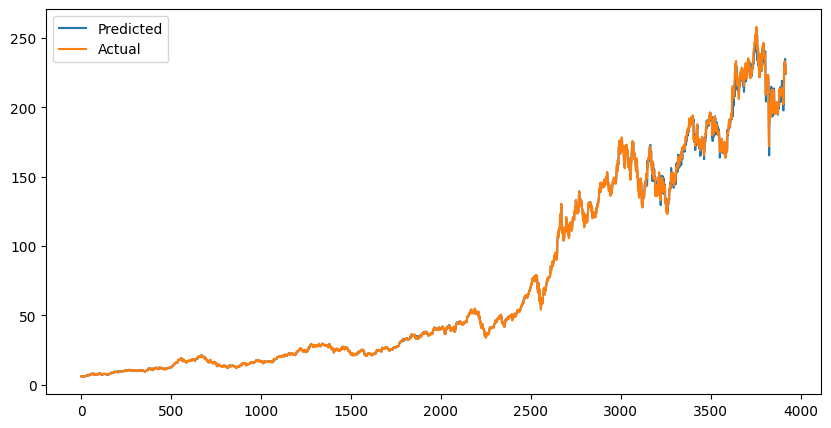

In [29]:
plot_values(df, 0.2)

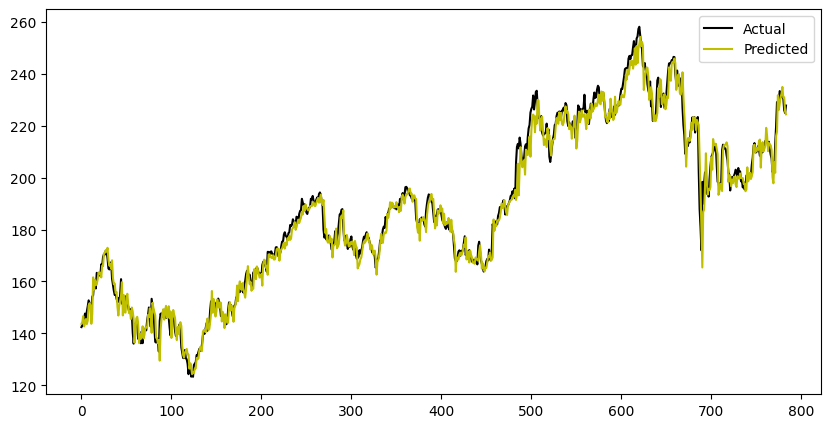

In [37]:
plt.plot(Y_test.reshape(-1), label='Actual', color='k')
plt.plot(predictions.reshape(-1), label='Predicted', color='y')
plt.legend()
plt.show()

#### Prediciendo el dia siguiente

In [38]:
last_row

,open,adjusted_close,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close_diff_1,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-22,226.17000000,227.76000000,42445300,4,3,8,2025,234,22,34,2.86000000,224.90000000,227.42530000,226.95422042,5.80422340,1.61053640,3.68000000,11.51705595,NaN


In [39]:
prediction = xgb_prediction(df.values, last_row.values[0][:-1])
prediction

227.47115

In [ ]:
model.save_model('model.json')

In [368]:
# # Create an empty model object
# loaded_model = xgb.Booster()

# # Load from the JSON file
# loaded_model.load_model('model.json')

# # Use it for predictions
# preds = loaded_model.predict(dtest)

### Otras pruebas

#### Linear Regression

In [192]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [193]:
y_pred_lr = lr_model.predict(X_test)

In [194]:
print(metrics.mean_squared_error(y_test, y_pred_lr))
print(metrics.r2_score(y_test, y_pred_lr))

0.00034151233409805725
-0.004104839776136737


``R2``

1 → modelo perfecto.

0 → igual que predecir siempre la media.

< 0 → peor que predecir siempre la media.

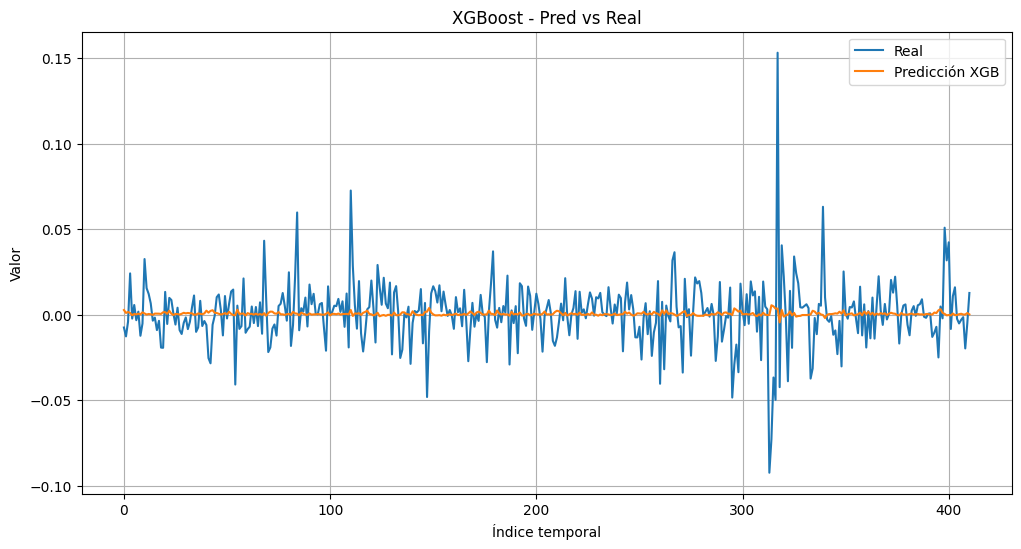

In [363]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred_lr.reshape(-1), label="Predicción XGB")

plt.title("XGBoost - Pred vs Real")
plt.xlabel("Índice temporal")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

#### Random Forest Regressor

In [195]:
tscv = TimeSeriesSplit(n_splits=5)

In [196]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [198]:
rf_param_grid = {
    "n_estimators": [200, 400, 600],              # suficiente para estabilizar sin disparar coste
    "max_depth": [2, 5, 10, 15, None],          # controla overfitting; None solo como control
    "min_samples_split": [2, 5, 10, 20],        # sube el mínimo para suavizar árboles
    "min_samples_leaf": [2, 4, 8, 12],           # hojas más grandes = menos ruido
    "max_features": ["sqrt", "log2", 0.2, 0.5, 0.8],      # menos correlación entre árboles
    "bootstrap": [True],                     # deja True para poder usar max_samples
    "max_samples": [0.7, 0.9],               # submuestreo → menor varianza, útil en TS
    "ccp_alpha": [0.0, 1e-3, 1e-6]                 # pequeña poda por complejidad
}

# rf_param_grid = {
#     "n_estimators": [400],              # suficiente para estabilizar sin disparar coste
#      "max_depth": [2],          # controla overfitting; None solo como control
#      "min_samples_split": [2, 5, 10, 20],        # sube el mínimo para suavizar árboles
#      "min_samples_leaf": [2],           # hojas más grandes = menos ruido
#      "max_features": ["sqrt"],      # menos correlación entre árboles
#      "bootstrap": [True],                     # deja True para poder usar max_samples
#      "max_samples": [0.7],               # submuestreo → menor varianza, útil en TS
#      "ccp_alpha": [1e-3] 
# }

In [199]:
gcv = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    refit=True,        # re‑entrena con el mejor set en todo el train
    verbose=1,
    n_jobs=-1
)

In [200]:
gcv.fit(X_train,y_train)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.0, 0.001, 1e-06],
                         'max_depth': [2, 5, 10, 15, None],
                         'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8],
                         'max_samples': [0.7, 0.9],
                         'min_samples_leaf': [2, 4, 8, 12],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [200, 400, 600]},
             scoring='neg_mean_squared_error', verbose=1)

In [201]:
best_rf = gcv.best_estimator_
y_pred_rf = best_rf.predict(X_test)

In [203]:
print(metrics.mean_squared_error(y_test, y_pred_rf))
print(metrics.r2_score(y_test, y_pred_rf))

0.0003421571150257252
-0.006000606298820932


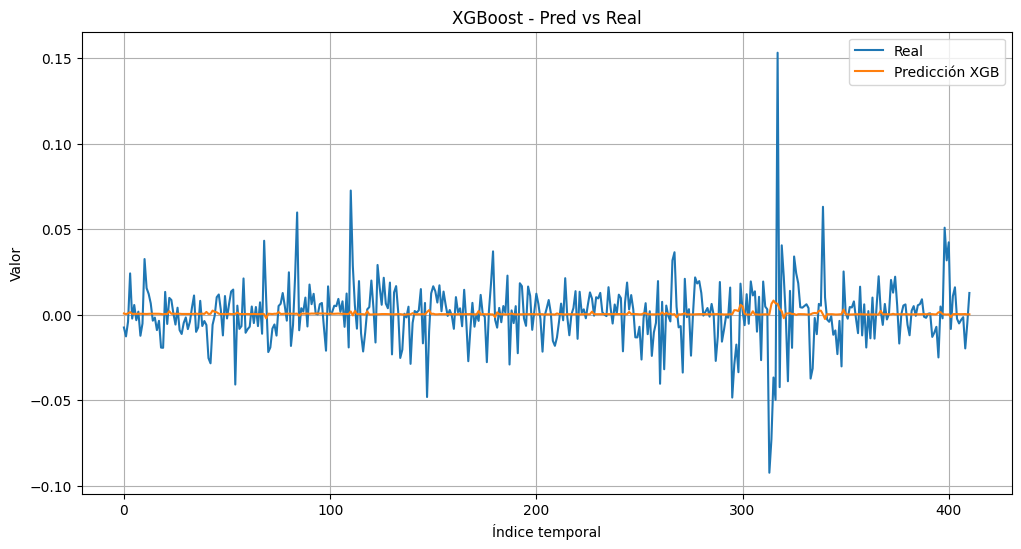

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred_rf, label="Predicción XGB")

plt.title("XGBoost - Pred vs Real")
plt.xlabel("Índice temporal")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

#### XGBoost

XGBoost (y otros boosters) entrenan con muchos árboles ``(n_estimators=2000)``.

No sabemos cuántos árboles son “suficientes”: si ponemos demasiados, puede sobreajustar; si pocos, puede quedarse corto.

La solución → **``Early stopping``**

Durante el entrenamiento, le damos a XGBoost un conjunto de validación (val).

El modelo va construyendo árbol tras árbol…

Si después de, digamos, 100 árboles nuevos no mejora en el set de validación → se para automáticamente.

Así encuentra el número óptimo de árboles sin que tú lo adivines.

**Por qué necesitamos un hold-out temporal dentro del TRAIN**

No podemos usar el test para early stopping (sería hacer trampa: mirar el futuro).

Entonces, dentro de tu X_train, hacemos un split temporal:

``X_tr, y_tr → parte inicial del train (ej. 80%).``

``X_val, y_val → parte final del train (ej. 20%).``

XGBoost usa X_val, y_val solo para early stopping.

Luego, cuando termines, el test real (2024+) queda limpio para evaluar.

Es lo mismo que decir:

“Mira, entrena con el pasado hasta 2022… pero te voy a dar 2023 para que vayas chequeando si te estás pasando de la raya. Si ya no mejoras en 2023, párate ahí.”

In [205]:
xgb_model = XGBRegressor(
    objective="reg:squarederror", 
    device = 'cuda',
    random_state=42,
    eval_metric="rmse"
)

In [206]:
xgb_param_dist = {
    "n_estimators": [200, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0]
}

In [224]:
rsearch = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring="r2",
    cv=tscv,                  # respeta el orden temporal
    refit=True,
    random_state=42,
    verbose=1
)

In [225]:
rsearch.fit(X_train, y_train)
print("Mejores hiperparámetros (sin ES):", rsearch.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros (sin ES): {'subsample': 1.0, 'reg_lambda': 5.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


In [227]:
best_no_es = rsearch.best_estimator_
y_pred_xgb = best_no_es.predict(X_test)
print("TEST MSE (sin ES):", metrics.mean_squared_error(y_test, y_pred_xgb))
print("TEST R^2  (sin ES):", metrics.r2_score(y_test, y_pred_xgb))

TEST MSE (sin ES): 0.00034970309650654346
TEST R^2  (sin ES): -0.02818708616860821


In [228]:
split = int(len(X_train) * 0.8)
X_tr, X_val = X_train.iloc[:split], X_train.iloc[split:]
y_tr, y_val = y_train.iloc[:split], y_train.iloc[split:]

In [229]:
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=list(X_train.columns))
dval   = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_train.columns))
dtest  = xgb.DMatrix(X_test,              feature_names=list(X_train.columns))

Convertir a ``DMatrix`` es solo un paso de optimización interna → transforma tus pandas DataFrame a un formato especial que XGBoost necesita para entrenar eficientemente.

In [230]:
best = rsearch.best_params_.copy()

In [231]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": best.get("max_depth", 3),
    "subsample": best.get("subsample", 1.0),
    "colsample_bytree": best.get("colsample_bytree", 0.7),
    "lambda": best.get("reg_lambda", 5.0),   # 'lambda' = reg_lambda
    "eta": best.get("learning_rate", 0.01),  # 'eta' = learning_rate
    "device": "cuda",                   # CPU por defecto
    "seed": 42
}

In [232]:
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,                      # alto; que el ES decida
    evals=[(dtrain, "train"), (dval, "val")],  # val se usa para ES
    early_stopping_rounds=200,                 # se para si no mejora
    verbose_eval=False
)

In [233]:
booster.best_iteration

82

In [234]:
y_pred_xgb = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

In [235]:
mse = metrics.mean_squared_error(y_test, y_pred_xgb)
r2  = metrics.r2_score(y_test, y_pred_xgb)
print(f"TEST MSE: {mse}")
print(f"TEST R^2:  {r2}")

TEST MSE: 0.00034173924659129575
TEST R^2:  -0.004772001427174155


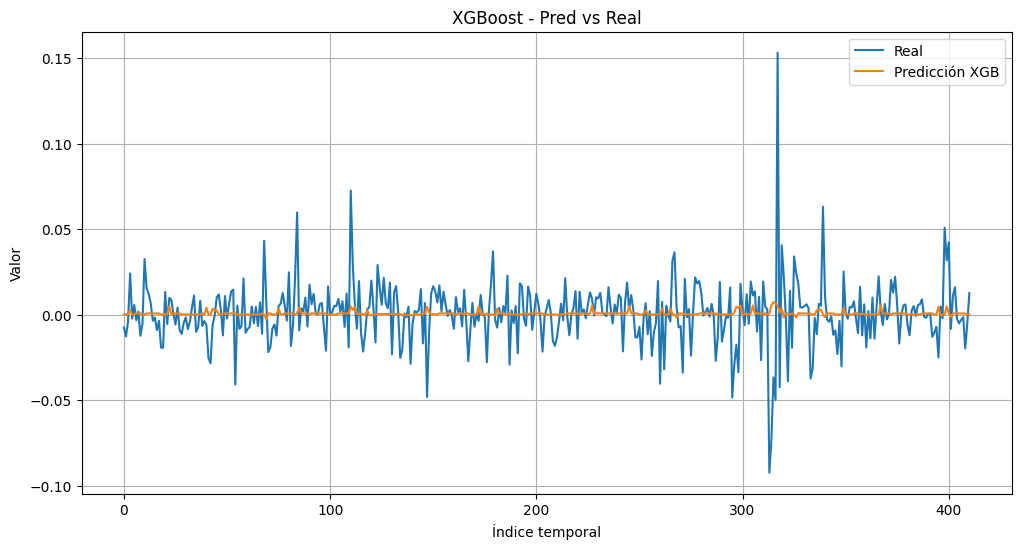

In [366]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred_xgb, label="Predicción XGB")

plt.title("XGBoost - Pred vs Real")
plt.xlabel("Índice temporal")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()